#GAN - MNIST

##Imports

In [0]:

%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



##Initialization

In [0]:

# Initialize Batch Size
batch_size = 64

# number of subprocesses to use for data loading
num_workers = 0

transform = transforms.ToTensor()

# Load Dataset
train_dataset = datasets.MNIST(root='data', train=True, download =True, transform=transform)

# Prepare the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers )


##Data Visualization

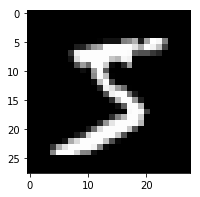

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
px = fig.add_subplot(111)
px.imshow(img, cmap='gray')

#GAN Model
##Discriminator


It is a linear classifier with 2 hidden layers. This network uses leaky ReLU as an activation function.
A leaky ReLU is a normal ReLU function but it return small non-zero value for negative inputs. We use leaky ReLU so gradients can backward propagate without hinderance.

Using a BCEWithLogitsLoss which combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable. Source: [Documentation](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    
    # Layers
    self.conv1 = nn.Linear(input_size, hidden_dim*4)    # Input Layer
    self.conv2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.conv3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.conv4 = nn.Linear(hidden_dim, output_size)  # Final Layer
    
    # Dropout layer
    self.dropout = nn.Dropout(0.3)
    
  def forward(self, x):
    # Flatten image
    x = x.view(-1, 28*28)
      
    x = F.leaky_relu(self.conv1(x), 0.2)   # (input, negative_slope)
    x = self.dropout(x)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.dropout(x)
     
    # Final Layer
    out = self.conv4(x)
    return out
    
 
  

##Add Generator

Works like the Discriminator but use tanh as an activation function in the output layer.
Generator works best when tanh is scaled between -1 and 1.
So we will have to scale our real input images to have pixel values between -1 and 1 when we train the discriminator.

In [0]:
class Generator(nn.Module):
  
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    
    # Layers
    self.conv1 = nn.Linear(input_size, hidden_dim)    # Input Layer
    self.conv2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.conv3 = nn.Linear(hidden_dim*2, hidden_dim*4)
    self.conv4 = nn.Linear(hidden_dim*4, output_size)  # Final Layer
    
    # Dropout layer
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)   # (input, negative_slope)
    x = self.dropout(x)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.dropout(x)
     
    # Final Layer
    output = F.tanh(self.conv4(x))
      
    return output
    
   
  

##Model Hyperparameters

In [0]:
# Discriminator Hyperarameters

# Size of input image
input_size = 784
# Size of discriminator output
d_output_size = 1
# Size of last hidden layer in discriminator (layer 3)
d_hidden_size = 32


# Generator Hyperparamters

# Size of latent vector to give to Generator (reffered as noise)
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer
g_hidden_size = 32



##Building Network
Instantiating the current network

In [8]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)


Discriminator(
  (conv1): Linear(in_features=784, out_features=128, bias=True)
  (conv2): Linear(in_features=128, out_features=64, bias=True)
  (conv3): Linear(in_features=64, out_features=32, bias=True)
  (conv4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (conv1): Linear(in_features=100, out_features=32, bias=True)
  (conv2): Linear(in_features=32, out_features=64, bias=True)
  (conv3): Linear(in_features=64, out_features=128, bias=True)
  (conv4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


##Discriminator and Generator Losses
###Discriminator Loss
*  Total loss = real loss + fake loss (d_loss = d_real_loss + d_fake_loss)
*   Output = 1 for real images
*   Output = 0 for fake images
*   Using BCEWithLogitsLoss
*   To generalize better we reduce the real label classification limit to 0.9 - 1.0, using *smooth* parmeter for this
*   Generator outputs images, we want D(fake_images) = 0

###Generator Loss
*   Similar to Discriminator only flipped, D(fake_images) = 1
*   The labels are flipped to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!


In [0]:

# Calculating losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss



##Optimizers
Updating generator and discriminator separately. Assigning two separate Adam optimizers.

In [0]:
import torch.optim as optim

# Learning Rate
lr = 0.002

# Optimizers
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)


##Training
We will use real_loss and fake_loss to calculate losses in all the following cases
###Discriminator
*   Compute discriminator loss on real, training images
*   Generate fake images
*   Compute loss on fake (generated) images
*   Add real and fake loss
*   Perform backpropagation + an optimization step to update discriminator weights

###Generator
*   Generate fake images
*   Compute discriminator loss on fake (generated) images
*   Perform backpropagation + an optimization step to update generator weights

###Saving Samples
As we train, we printout loss statistics and save images

In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        #  TRAIN THE DISCRIMINATOR
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        

        #  TRAIN THE GENERATOR
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    # AFTER EACH EPOCH
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3992 | g_loss: 0.7484
Epoch [    1/  100] | d_loss: 1.0931 | g_loss: 1.5593
Epoch [    1/  100] | d_loss: 0.9760 | g_loss: 2.3195
Epoch [    2/  100] | d_loss: 0.7339 | g_loss: 3.8131
Epoch [    2/  100] | d_loss: 1.3849 | g_loss: 0.6767
Epoch [    2/  100] | d_loss: 0.9668 | g_loss: 2.0296
Epoch [    3/  100] | d_loss: 1.4315 | g_loss: 0.6674
Epoch [    3/  100] | d_loss: 1.0626 | g_loss: 2.0613
Epoch [    3/  100] | d_loss: 0.8987 | g_loss: 1.9366
Epoch [    4/  100] | d_loss: 1.0449 | g_loss: 1.1931
Epoch [    4/  100] | d_loss: 1.1475 | g_loss: 1.0485
Epoch [    4/  100] | d_loss: 1.0689 | g_loss: 1.3453
Epoch [    5/  100] | d_loss: 1.1927 | g_loss: 1.0090
Epoch [    5/  100] | d_loss: 0.9082 | g_loss: 1.4851
Epoch [    5/  100] | d_loss: 1.1532 | g_loss: 1.1206
Epoch [    6/  100] | d_loss: 1.2625 | g_loss: 1.2479
Epoch [    6/  100] | d_loss: 1.1051 | g_loss: 1.8081
Epoch [    6/  100] | d_loss: 1.3676 | g_loss: 0.8761
Epoch [    7/  100] | d_loss

##Training Loss
Plotting Training Loss for generator and Discriminator after each Epoch

In [0]:
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)
      
    
    

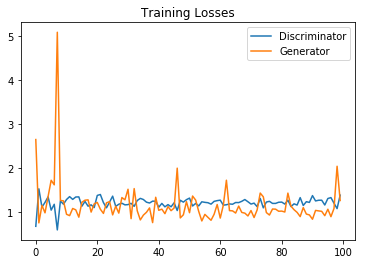

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

##Generator Samples from training
We can view samples of images from generator, First we take a look at the images we saved during training.


In [0]:
# Helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

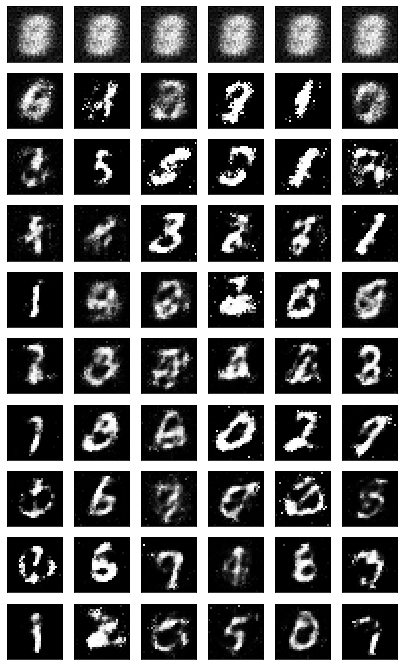

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


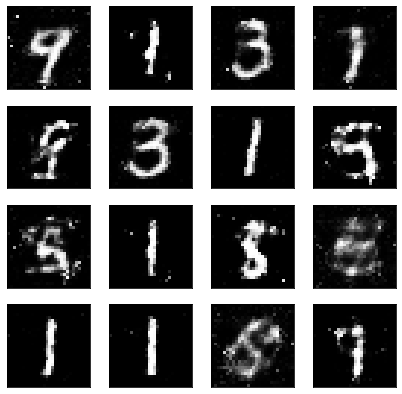

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])